In [20]:
import pandas as pd

# ============ 1.1 读取 TDA 结果（重命名后的 CSV） ============
tda_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_results_merged_new.csv"
df_tda = pd.read_csv(tda_path, parse_dates=["date"])

# ============ 1.2 读取 SP500 / VIX ============
index_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/股票指数与金融恐慌指数.xlsx"
df_index = pd.read_excel(index_path, sheet_name="^GSPC_historical_data", parse_dates=["Date"])

# 统一日期列名
df_index = df_index.rename(columns={"Date": "date"})

# 确保 SP500 / VIX 列名与你文件匹配，如不一致在这里改
# 例如如果是 "Adj Close" 等，要先构造 SP500 列
# df_index = df_index.rename(columns={"Adj Close": "SP500"})

# ============ 1.3 读取 BTC 波动率 ============
btc_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/另一个波动率数据.xlsx"
df_btc = pd.read_excel(btc_path, parse_dates=["Date"])
df_btc = df_btc.rename(columns={"Date": "date"})

df_btc["vol_btc_parkinson"]    = df_btc["Parkinson_Volatility_BTC"]
df_btc["vol_btc_rogers"]       = df_btc["Rogers_Volatility_BTC"]

# 只保留需要的列
df_btc = df_btc[["date", "vol_btc_parkinson", "vol_btc_rogers"]]

# ============ 1.4 读取 Fear & Greed Index ============
fng_path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/fear_and_greed_index.csv"

df_fng = pd.read_csv(fng_path)

# 转换日期格式
df_fng["Date"] = pd.to_datetime(df_fng["Date"])

# 统一列名
df_fng = df_fng.rename(columns={"Date": "date"})

# ============ 1.4 合并成一个总 df ============
df = (
    df_tda
    .merge(df_index[["date", "SP500", "VIX"]], on="date", how="left")
    .merge(df_btc, on="date", how="left")
    .merge(df_fng, on="date", how="left")   # ← 新加的 Fear & Greed
    .sort_values("date")
    .reset_index(drop=True)
)

print(df.head())
print(df.info())

# ============ 1.5 保存最终合并后的数据 ============
out_path_csv = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_SP500_VIX_BTC_merged_new2.csv"

df.to_csv(out_path_csv, index=False)

print("✅ 合并后的数据已保存：")
print("CSV 文件：", out_path_csv)

   time_index       date  vol_wass_betti0  vol_wass_betti1  vol_wass_entropy  \
0           0 2020-08-21             1.26              0.0               0.0   
1           1 2020-08-22             1.24              0.0               0.0   
2           2 2020-08-23             1.22              0.0               0.0   
3           3 2020-08-24             1.26              0.0               0.0   
4           4 2020-08-25             1.28              0.0               0.0   

   log_wass_betti0  log_wass_betti1  log_wass_entropy  log_dtw_betti0  \
0             1.54              0.0               0.0            1.90   
1             1.62              0.0               0.0            1.94   
2             1.62              0.0               0.0            1.92   
3             1.72              0.0              -0.0            2.02   
4             1.64              0.0               0.0            1.96   

   log_dtw_betti1  log_dtw_entropy  vol_dtw_betti0  vol_dtw_betti1  \
0         

结果显示，所有的Betti0 TDA指标均优于VIX，优于股票市场收益与波动率，拓扑指标是最强的事件检测器。
金融意义：传统股票市场指标与加密货币事件不同步，加密市场的危机与反应机制往往独立于股票市场，因此，S&P500收益对加密事件几乎无反应（AUC=0.409），股市波动率也只能部分反应跨市场风险（AUC=0.556）。VIX恐慌指数反映的是股票市场的预期波动，它与部分宏观事件重叠，但无法捕捉许多“加密领域内部冲击”（如交易所暴雷、链上清算等）。加密市场事件本质上是结构性冲击，而不是单点价格变化，价格波动常常滞后，而结构变化（相关关系断裂，流动性消失）往往先发生。

拓扑机制的解释，TDA的Betti0描述连通分支数量的变化，这是检测结构重构最敏感的拓扑特征。一方面，市场危机导致相关结构分裂，资产之间的Wasserstein或DTW距离突然增大，网络结构断裂，Betti0激增或下降。另一方面，结构性变化早于价格变化。市场在暴雷之前往往出现流动性枯竭，价格行为模式不一致、同步性解耦，这些都直接改变VR复形拓扑结构。Betti0捕捉到正是“市场是否仍然连在一起”，这是金融风险最关键的维度，比单点价格波动更根本。

BTC是加密货币市场的基准资产，BTC波动率常被视为整个crypto market的情绪温度计，因此我们在基准测试的第二部分引入BTC波动率作为基准风险指标，对比TDA指标是否更好地检测市场事件。

为了进一步评估拓扑指标相对于传统金融风险度量的优势，我们将其与两类常用的基于比特币价格区间的波动率指标进行比较，分别是Parkinson波动率和Rogers Satchell波动率。由于比特币在加密货币市场中占据主导地位，其市场行为常被视为整个加密市场系统性压力的晴雨表，因此这类波动率通常能够有效反映市场的总体风险水平。

In [77]:
import pandas as pd
from datetime import timedelta

df = df.copy()   # 你的 df 就是上面那 18 列的最新表

events = [
    "2020-12-01","2021-01-02","2021-01-07","2021-01-29","2021-02-16","2021-03-13",
    "2021-04-10","2021-05-12","2021-05-17","2021-05-18","2021-05-19","2021-06-09",
    "2021-09-24","2021-10-15","2021-11-15",
    "2022-04-27","2022-05-01","2022-05-11","2022-05-12","2022-05-13","2022-07-20",
    "2022-11-01","2023-03-01","2023-03-10","2023-05-17","2023-06-16","2023-07-01",
    "2023-10-01","2024-03-19","2024-04-20","2025-01-20","2025-02-03","2025-02-21",
    "2025-03-07","2025-05-20","2025-06-05","2025-06-17"
]
events = pd.to_datetime(events)

# === ±30 天窗口 ===
window = 10
df["event_label"] = 0

for e in events:
    df.loc[(df["date"] >= e - timedelta(days=window)) &
           (df["date"] <= e + timedelta(days=window)), "event_label"] = 1

print(df["event_label"].value_counts())

event_label
0    1268
1     585
Name: count, dtype: int64


In [78]:
df["SP500"] = df["SP500"].ffill() # 用最近一个有效值填缺失的天
df["VIX"] = df["VIX"].ffill() # 用最近一个有效值填缺失的天

df["sp_ret"] = df["SP500"].pct_change() # 对数差分
df["sp_vol7"] = df["sp_ret"].rolling(7).std() # 取 SP500 的每日收益率（sp_ret），按过去 7 天为一个窗口计算标准差，作为 7 日滚动波动率。
df["VIX"] = df["VIX"]
df["fear&greed"] = df["fng_value"]

In [79]:
tda_indicators = [
    "vol_wass_betti0","vol_wass_betti1","vol_wass_entropy",
    "log_wass_betti0","log_wass_betti1","log_wass_entropy",
    "log_dtw_betti0","log_dtw_betti1","log_dtw_entropy",
    "vol_dtw_betti0","vol_dtw_betti1","vol_dtw_entropy",
]

In [80]:
bench_indicators = [
    "VIX", "sp_ret", "sp_vol7",
    "vol_btc_parkinson","vol_btc_rogers","fear&greed"
]
all_indicators = tda_indicators + bench_indicators

In [81]:
from sklearn.metrics import roc_curve, auc
import numpy as np

results_auc = []
y_true = df["event_label"].to_numpy()

for col in all_indicators:
    y_score = df[col].to_numpy().astype(float)
    mask = np.isfinite(y_score)

    fpr, tpr, _ = roc_curve(y_true[mask], y_score[mask])
    roc_auc = auc(fpr, tpr)

    results_auc.append((col, roc_auc))

results_auc_sorted = sorted(results_auc, key=lambda x: x[1], reverse=True)

print("\n=== ROC–AUC Benchmark Results ===")
for name, v in results_auc_sorted:
    print(f"{name}: AUC = {v:.3f}")


=== ROC–AUC Benchmark Results ===
log_dtw_betti0: AUC = 0.663
log_wass_betti0: AUC = 0.652
vol_dtw_betti0: AUC = 0.650
vol_wass_betti0: AUC = 0.634
vol_btc_parkinson: AUC = 0.628
vol_btc_rogers: AUC = 0.625
fear&greed: AUC = 0.577
VIX: AUC = 0.550
log_dtw_entropy: AUC = 0.521
log_wass_betti1: AUC = 0.514
log_dtw_betti1: AUC = 0.511
vol_wass_betti1: AUC = 0.503
log_wass_entropy: AUC = 0.502
vol_wass_entropy: AUC = 0.502
sp_ret: AUC = 0.502
vol_dtw_betti1: AUC = 0.501
vol_dtw_entropy: AUC = 0.500
sp_vol7: AUC = 0.480


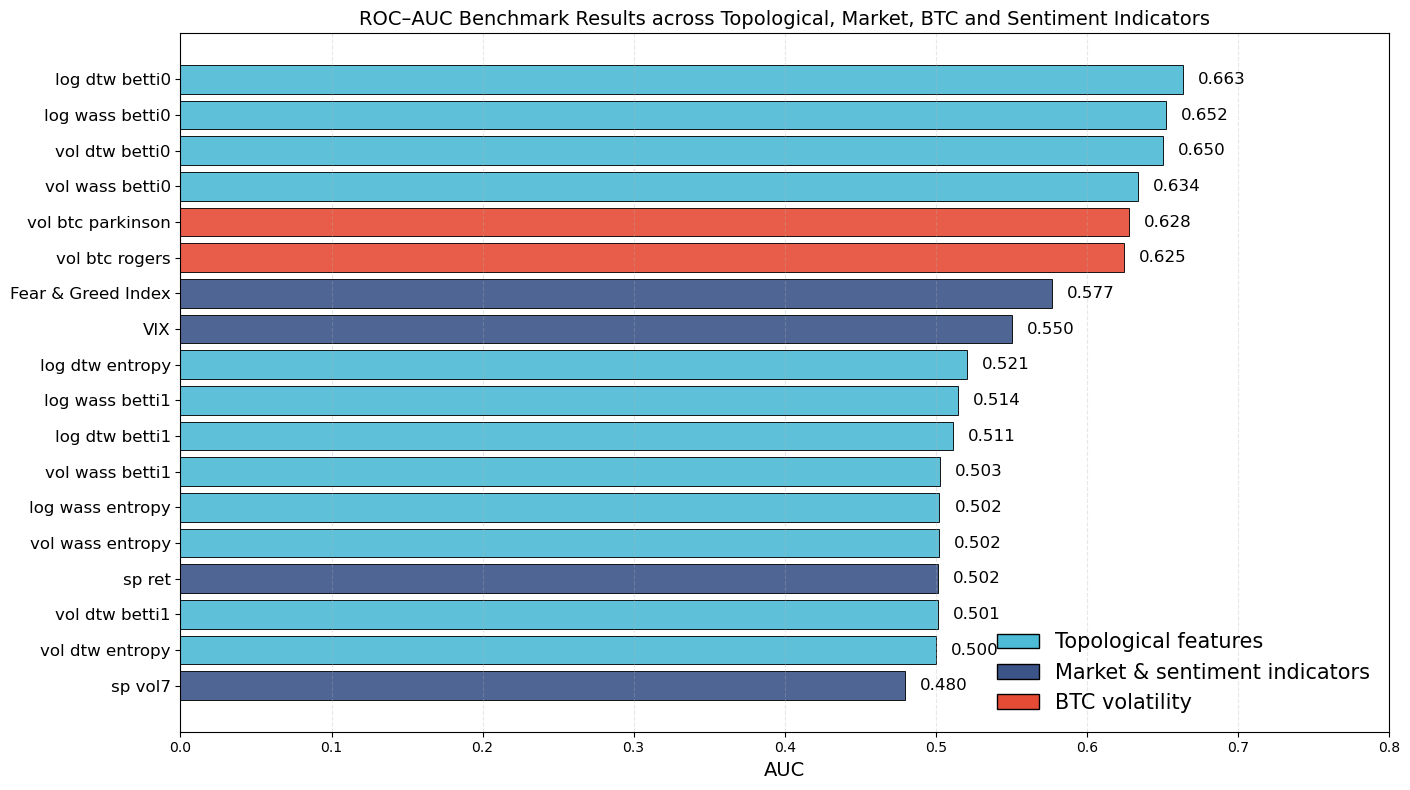

图已保存： /Users/jane/Documents/202511吾-Systems/4.Plot/Fig3/fig_auc_benchmark_nature_new(10).png


In [82]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# ========= 1) 将 AUC 结果转成 dict ==========
auc_dict = dict(results_auc_sorted)

# ========= 2) 标签 beautify（fear&greed 单独处理） ==========
label_map = {}
for name in auc_dict.keys():
    if name == "fear&greed":
        label_map[name] = "Fear & Greed Index"
    else:
        label_map[name] = name.replace("_", " ")

# ========= 3) 指标分组（请确保与前面的代码一致） ==========
tda_indicators = [
    "log_dtw_betti0","vol_dtw_betti0","log_wass_betti0","vol_wass_betti0",
    "log_dtw_entropy","log_wass_betti1","vol_wass_betti1","vol_dtw_betti1",
    "vol_wass_entropy","log_dtw_betti1","log_wass_entropy","vol_dtw_entropy"
]

market_indicators = [
    "SP500","sp_ret","sp_vol7","VIX","vix_change","fear&greed"
]

btc_indicators = [
    "vol_btc_parkinson","vol_btc_rogers"
]

# ========= 4) 配色（Nature 风） ==========
color_tda = "#4DBBD5"   # TDA 蓝绿
color_market = "#3C5488"  # 市场深蓝
color_btc = "#E64B35"     # BTC 橙红

def get_color(name):
    if name in tda_indicators:
        return color_tda
    elif name in market_indicators:
        return color_market
    elif name in btc_indicators:
        return color_btc
    else:
        return "#999999"  # fallback

# ========= 5) 生成绘图数据 ==========
names = list(auc_dict.keys())
auc_vals = list(auc_dict.values())
colors = [get_color(n) for n in names]

y_pos = np.arange(len(names))

# ========= 6) 开始绘图 ==========
fig, ax = plt.subplots(figsize=(14.2, 8))

bars = ax.barh(
    y_pos, auc_vals,
    color=colors,
    edgecolor="black",
    linewidth=0.7,
    alpha=0.9
)

ax.set_yticks(y_pos)
ax.set_yticklabels([label_map[n] for n in names], fontsize=12)

# 反转 y 轴（最高的在最上）
ax.invert_yaxis()

# AUC 范围
ax.set_xlim(0, 0.8)

ax.set_xlabel("AUC", fontsize=14)
ax.set_title("ROC–AUC Benchmark Results across Topological, Market, BTC and Sentiment Indicators",
             fontsize=14)

# 网格
ax.xaxis.grid(True, linestyle="--", alpha=0.3)

# AUC 数值显示
for bar, v in zip(bars, auc_vals):
    ax.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height()/2,
        f"{v:.3f}",
        va="center", ha="left", fontsize=12
    )

# ========= 7) 图例 ==========
legend_handles = [
    Patch(facecolor=color_tda, edgecolor="black",   label="Topological features"),
    Patch(facecolor=color_market, edgecolor="black", label="Market & sentiment indicators"),
    Patch(facecolor=color_btc, edgecolor="black",    label="BTC volatility"),
]

ax.legend(handles=legend_handles, fontsize=15, frameon=False, loc="lower right")

plt.tight_layout()

# 保存为 900 dpi
save_path = "/Users/jane/Documents/202511吾-Systems/4.Plot/Fig3/fig_auc_benchmark_nature_new(10).png"
fig.savefig(save_path, dpi=900, bbox_inches="tight")

plt.show()

print("图已保存：", save_path)

每个 TDA 指标、SP500 指标、BTC 波动率指标，在 PELT / BinSeg / CUSUM 中的检测能力如何？（±30 天事件匹配 F1）

In [5]:
import pandas as pd

# 文件路径
path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_SP500_VIX_BTC_merged_new2.csv"

# 读取 CSV
df = pd.read_csv(path)

# 查看前 5 行
print("=== Head (前 5 行) ===")
print(df.head())

# 查看列名
print("\n=== Columns (列名) ===")
print(df.columns.tolist())

# 查看数据类型
print("\n=== Data Types (数据类型) ===")
print(df.dtypes)

# 查看缺失情况
print("\n=== Missing Values (缺失情况) ===")
print(df.isna().sum())

# 数据维度（行数、列数）
print("\n=== Shape (维度) ===")
print(df.shape)

=== Head (前 5 行) ===
   time_index        date  vol_wass_betti0  vol_wass_betti1  vol_wass_entropy  \
0           0  2020-08-21             1.26              0.0               0.0   
1           1  2020-08-22             1.24              0.0               0.0   
2           2  2020-08-23             1.22              0.0               0.0   
3           3  2020-08-24             1.26              0.0               0.0   
4           4  2020-08-25             1.28              0.0               0.0   

   log_wass_betti0  log_wass_betti1  log_wass_entropy  log_dtw_betti0  \
0             1.54              0.0               0.0            1.90   
1             1.62              0.0               0.0            1.94   
2             1.62              0.0               0.0            1.92   
3             1.72              0.0              -0.0            2.02   
4             1.64              0.0               0.0            1.96   

   log_dtw_betti1  log_dtw_entropy  vol_dtw_betti0  v

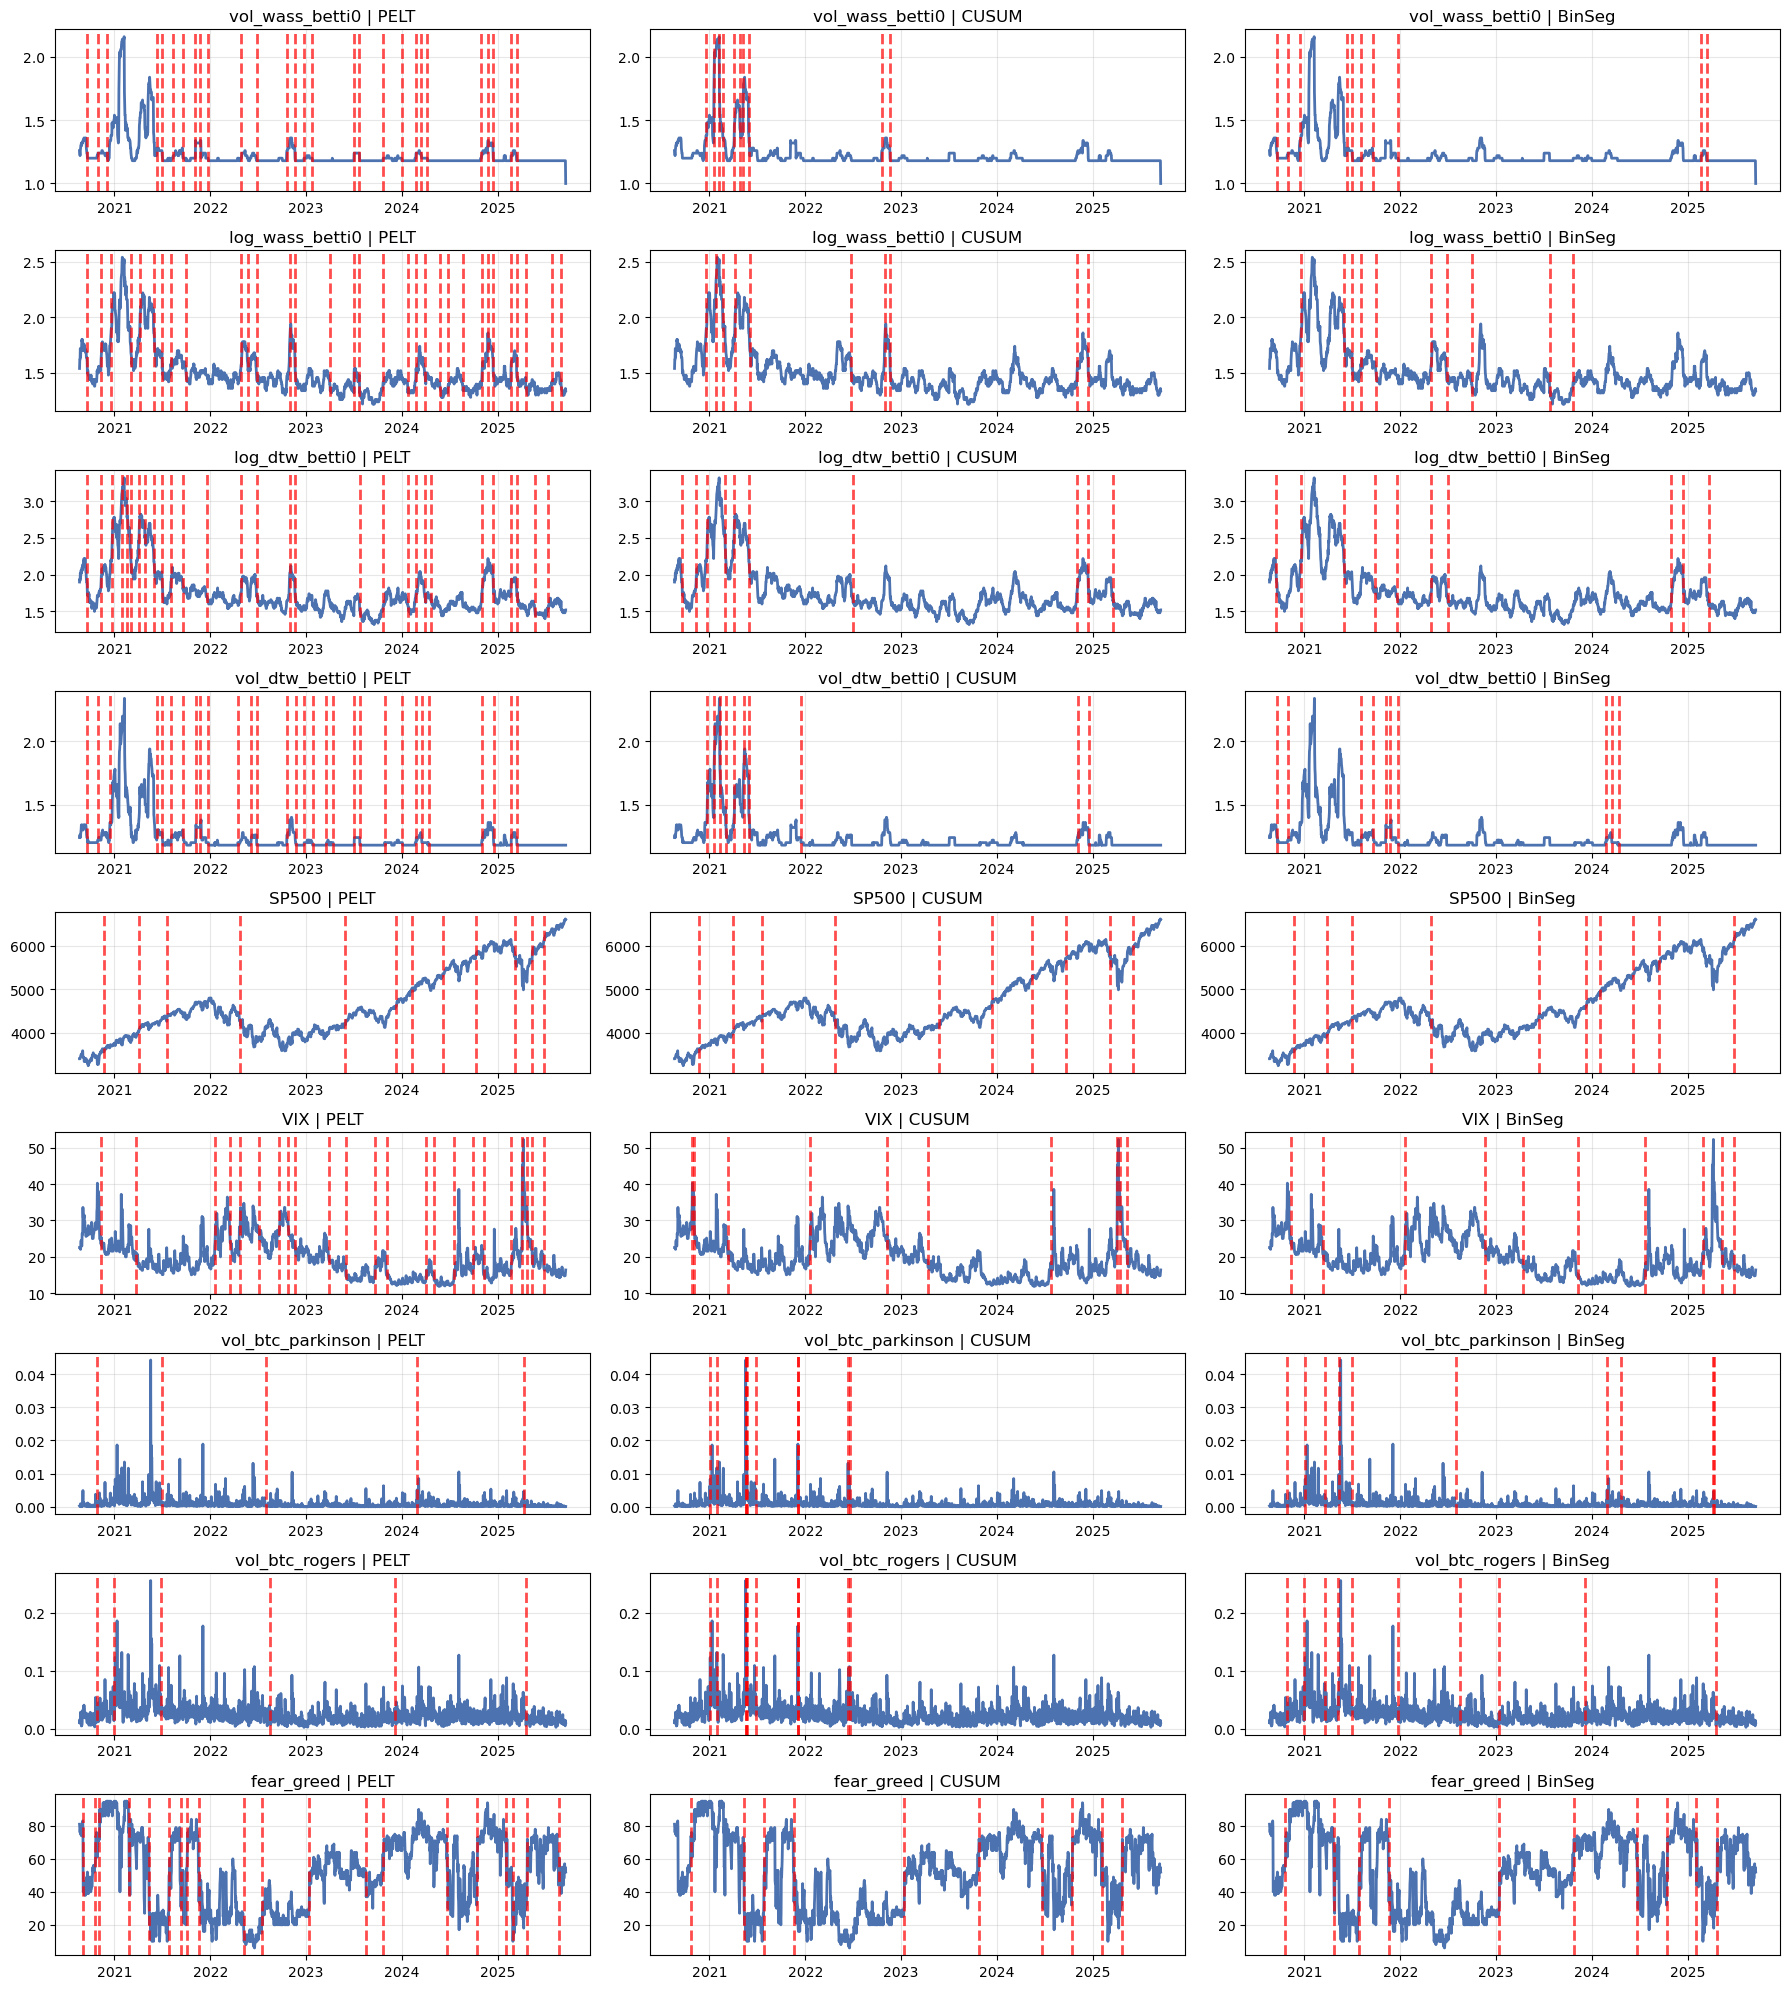

保存成功： /Users/jane/Documents/202511吾-Systems/4.Plot/Fig3/fig_changepoint_all_8ind_3methods_new.png


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruptures as rpt

# ============================================================
# 1. 读取数据
# ============================================================
path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_SP500_VIX_BTC_merged_new2.csv"
df = pd.read_csv(path, parse_dates=["date"])

df = df.sort_values("date").reset_index(drop=True)

# Fear & Greed 新列
df["fear_greed"] = df["fng_value"]

# ============================================================
# 2. 指标列表
# ============================================================
indicators = [
    "vol_wass_betti0",
    "log_wass_betti0",
    "log_dtw_betti0",
    "vol_dtw_betti0",
    "SP500",
    "VIX",
    "vol_btc_parkinson",
    "vol_btc_rogers",
    "fear_greed"
]

# ============================================================
# 3. 缺失值处理（稳健版本）
# ============================================================
df[indicators] = df[indicators].ffill().bfill()

# 时间轴
dates = df["date"]

# ============================================================
# 4. 三种方法统一封装（修复二维问题）
# ============================================================
def detect_cps(series, method, n_bkps=10):

    x = series.values.astype(float).reshape(-1, 1)  # 重要：二维

    n = len(x)
    pen_val = np.log(n)

    if method == "PELT":
        algo = rpt.Pelt(model="rbf").fit(x)
        cps = algo.predict(pen=pen_val)

    elif method == "BinSeg":
        algo = rpt.Binseg(model="rbf").fit(x)
        cps = algo.predict(n_bkps=n_bkps)

    elif method == "CUSUM":
        algo = rpt.KernelCPD(kernel="linear").fit(x)
        cps = algo.predict(n_bkps=n_bkps)

    return cps[:-1]

methods = ["PELT", "CUSUM", "BinSeg"]

# ============================================================
# 5. 创建总画布
# ============================================================
fig, axes = plt.subplots(
    nrows=len(indicators), ncols=len(methods),
    figsize=(18, 20), sharex=False
)

for i, ind in enumerate(indicators):

    y = df[ind]

    for j, method in enumerate(methods):

        ax = axes[i, j]
        cps = detect_cps(y, method=method)

        ax.plot(dates, y, lw=2, color="#4C72B0")

        for c in cps:
            ax.axvline(dates.iloc[c], color="red", linestyle="--", lw=2, alpha=0.7)

        ax.set_title(f"{ind} | {method}", fontsize=12)
        ax.grid(alpha=0.3)

plt.tight_layout()

# ============================================================
# 6. 保存图像
# ============================================================
out_path = "/Users/jane/Documents/202511吾-Systems/4.Plot/Fig3/fig_changepoint_all_8ind_3methods_new.png"
plt.savefig(out_path, dpi=900, bbox_inches="tight")
plt.show()

print("保存成功：", out_path)

In [30]:
import numpy as np
import pandas as pd
import ruptures as rpt
from datetime import timedelta
from sklearn.metrics import precision_score, recall_score, f1_score


# =====================================================
# 0) 读取并准备数据
# =====================================================

path = "/Users/jane/Documents/202511吾-Systems/3.Data_systems/TDA_SP500_VIX_BTC_merged_new2.csv"
df = pd.read_csv(path, parse_dates=["date"])
df = df.sort_values("date").reset_index(drop=True)

# 创建 Fear & Greed
df["fear_greed"] = df["fng_value"]

# 填充 SP500 和 VIX 缺失（必须，否则 ruptures 会崩溃）
df = df.ffill().bfill()


# =====================================================
# 1) 定义真实事件（Ground truth）
# =====================================================

events = pd.to_datetime([
    "2020-12-01","2021-01-02","2021-01-07","2021-01-29","2021-02-16","2021-03-13",
    "2021-04-10","2021-05-12","2021-05-17","2021-05-18","2021-05-19","2021-06-09",
    "2021-09-24","2021-10-15","2021-11-15",
    "2022-04-27","2022-05-01","2022-05-11","2022-05-12","2022-05-13","2022-07-20",
    "2022-11-01","2023-03-01","2023-03-10","2023-05-17","2023-06-16","2023-07-01",
    "2023-10-01","2024-03-19","2024-04-20","2025-01-20","2025-02-03","2025-02-21",
    "2025-03-07","2025-05-20","2025-06-05","2025-06-17"
])

# 过滤掉超过数据末尾的事件
events = events[events <= df["date"].max()]


# =====================================================
# 2) 检测函数（PELT / BinSeg / CUSUM）
# =====================================================
def detect_cps(series, method="PELT", n_bkps=10):

    # 转二维
    x = series.values.astype(float).reshape(-1, 1)
    n = len(x)
    pen_val = np.log(n)

    if method == "PELT":
        algo = rpt.Pelt(model="rbf").fit(x)
        cps = algo.predict(pen=pen_val)

    elif method == "BinSeg":
        algo = rpt.Binseg(model="rbf").fit(x)
        cps = algo.predict(n_bkps=n_bkps)

    elif method == "CUSUM":
        algo = rpt.KernelCPD(kernel="linear").fit(x)
        cps = algo.predict(n_bkps=n_bkps)

    return cps[:-1]


# =====================================================
# 3) change points 转日期
# =====================================================
def cp_to_dates(cps, dates):
    return [dates.iloc[c] for c in cps if c < len(dates)]


# =====================================================
# 4) 容忍窗口计算 F1
# =====================================================
def compute_f1_from_cps(cp_dates, events, window=10):

    all_dates = pd.date_range(start=min(events.min(), min(cp_dates, default=events.min())),
                              end=max(events.max(), max(cp_dates, default=events.max())))

    y_true = pd.Series(0, index=all_dates)
    y_pred = pd.Series(0, index=all_dates)

    # 标记真实事件窗口
    for e in events:
        y_true.loc[e - timedelta(days=window) : e + timedelta(days=window)] = 1

    # 标记预测窗口
    for c in cp_dates:
        y_pred.loc[c - timedelta(days=window) : c + timedelta(days=window)] = 1

    f1 = f1_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    return precision, recall, f1


# =====================================================
# 5) 针对 df 的指标循环计算 F1
# =====================================================

indicators = [
    "vol_wass_betti0", "log_wass_betti0",
    "log_dtw_betti0",  "vol_dtw_betti0",
    "SP500", "VIX",
    "vol_btc_parkinson", "vol_btc_rogers",
    "fear_greed"
]

methods = ["PELT", "BinSeg", "CUSUM"]

results = []

dates = df["date"]

for ind in indicators:
    y = df[ind]

    for m in methods:

        cps = detect_cps(y, method=m)
        cp_dates = cp_to_dates(cps, dates)

        precision, recall, f1 = compute_f1_from_cps(cp_dates, events, window=10)

        results.append([ind, m, precision, recall, f1])


df_results = pd.DataFrame(results, columns=["indicator", "method", "precision", "recall", "f1"])
print(df_results)

            indicator  method  precision    recall        f1
0     vol_wass_betti0    PELT   0.332168  0.330435  0.331299
1     vol_wass_betti0  BinSeg   0.404040  0.139130  0.206986
2     vol_wass_betti0   CUSUM   0.677083  0.230088  0.343461
3     log_wass_betti0    PELT   0.324575  0.358974  0.340909
4     log_wass_betti0  BinSeg   0.357143  0.132743  0.193548
5     log_wass_betti0   CUSUM   0.514286  0.191150  0.278710
6      log_dtw_betti0    PELT   0.441379  0.437607  0.439485
7      log_dtw_betti0  BinSeg   0.405000  0.140870  0.209032
8      log_dtw_betti0   CUSUM   0.375000  0.130435  0.193548
9      vol_dtw_betti0    PELT   0.306056  0.325217  0.315346
10     vol_dtw_betti0  BinSeg   0.365979  0.123478  0.184655
11     vol_dtw_betti0   CUSUM   0.607656  0.224779  0.328165
12              SP500    PELT   0.422414  0.168675  0.241082
13              SP500  BinSeg   0.389474  0.127367  0.191958
14              SP500   CUSUM   0.495000  0.173077  0.256477
15                VIX   

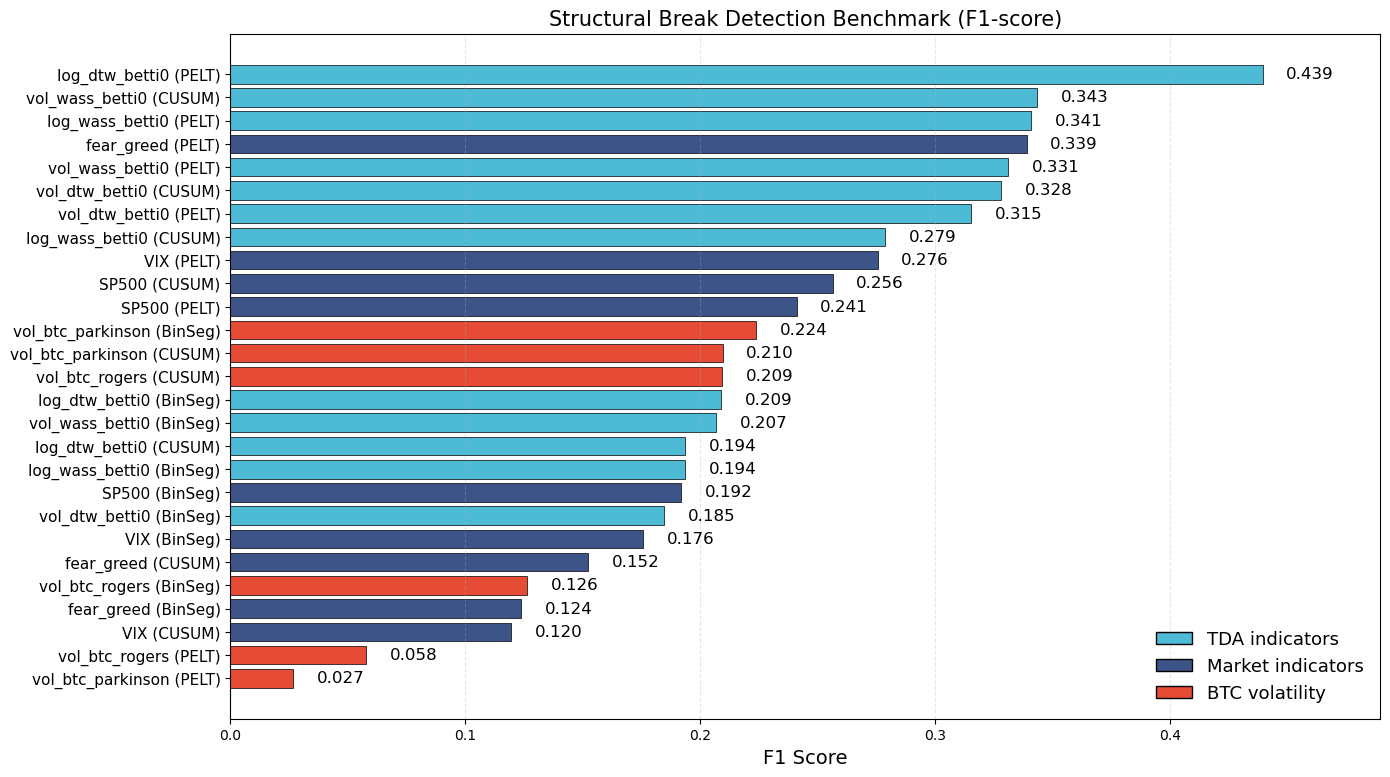

图已保存到： /Users/jane/Documents/202511吾-Systems/4.Plot/Fig3/fig_f1_benchmark_16by9_new(10).png


In [31]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

# ========== 1. 排序 ==========
df_plot = df_results.sort_values("f1", ascending=True).reset_index(drop=True)

# ========== 2. 定义颜色映射 ==========
color_tda    = "#4DBBD5"  # 蓝绿：TDA 特征
color_market = "#3C5488"  # 深蓝：传统市场指标（SP500, VIX, FearGreed）
color_btc    = "#E64B35"  # 橙红：BTC 波动率

def get_color(ind):

    # TDA 类
    if ("betti" in ind) or ("wass" in ind) or ("dtw" in ind):
        return color_tda

    # 传统市场指标
    if ind in ["SP500", "VIX", "fear_greed"]:
        return color_market

    # BTC 波动率
    if "btc" in ind:
        return color_btc

    # 其他（默认灰色）
    return "#999999"

colors = [get_color(ind) for ind in df_plot["indicator"]]

# ========== 3. 标签 = “指标 + (方法)” ==========
labels = [
    f"{row['indicator']} ({row['method']})"
    for _, row in df_plot.iterrows()
]

y = np.arange(len(df_plot))

# ========== 4. 16:9 画布 ==========
fig, ax = plt.subplots(figsize=(14, 7.875))   # 16:9

bars = ax.barh(y, df_plot["f1"], color=colors, edgecolor="black", linewidth=0.5)

# 数值标注
for i, bar in enumerate(bars):
    ax.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{df_plot['f1'].iloc[i]:.3f}",
        va="center", ha="left", fontsize=12
    )

# y 轴标签
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=11)

# x 轴
ax.set_xlabel("F1 Score", fontsize=14)
ax.set_xlim(0, max(df_plot["f1"]) + 0.05)

# 标题
ax.set_title("Structural Break Detection Benchmark (F1-score)", fontsize=15)

# x 轴 grid
ax.xaxis.grid(True, linestyle="--", alpha=0.3)
ax.yaxis.grid(False)

# 去掉顶部和右侧边框
ax.spines["top"].set_visible(True)
ax.spines["right"].set_visible(True)

# 图例
legend_handles = [
    Patch(facecolor=color_tda, edgecolor="black", label="TDA indicators"),
    Patch(facecolor=color_market, edgecolor="black", label="Market indicators"),
    Patch(facecolor=color_btc, edgecolor="black", label="BTC volatility"),
]

ax.legend(handles=legend_handles, fontsize=13, loc="lower right", frameon=False)

plt.tight_layout()

# ========== 5. 保存 ==========
out_path = "/Users/jane/Documents/202511吾-Systems/4.Plot/Fig3/fig_f1_benchmark_16by9_new(10).png"
plt.savefig(out_path, dpi=900, bbox_inches="tight", transparent=True)

plt.show()
print("图已保存到：", out_path)